# Introduction

This notebook translates the disorders in the [DSM-5](https://dsm.psychiatryonline.org/doi/book/10.1176/appi.books.9780890425596) into the language of the psychiatric neuroimaging literature. The objective is to maximize semantic similarity between the centroid of seed terms from the DSM-5 (i.e., disorder names) and the centroid of a new list of terms for mental functions and dysfunctions. Seed terms are grouped by the headings in Section II of the DSM-5. The work flow is as follows:

1. Identify the most semantically similar terms to each domain centroid across list lengths.
2. Select the word list length that maximizes semantic similarity to the domain centroid.
3. Filter domains by document frequency of their assigned terms.

Our vector space model for semantic content is [GloVe](https://github.com/stanfordnlp/GloVe), which was trained on 42,000 psychiatric neuroimaging articles. The parameters for the GloVe model were a minimum word count of 5, window size of 15, and embedding dimension of 100 over 500 iterations.

# Load the data

In [1]:
import pandas as pd
from collections import OrderedDict
from ontology import *

In [2]:
vsm_version = 190428 # Version of GloVe embeddings
dtm_version = 190325 # Version of document-term matrix

## Vector space model

In [3]:
vsm = pd.read_csv("../data/text/glove_psy_n100_win15_min5_iter500_{}.txt".format(vsm_version), 
                  index_col=0, header=None, sep=" ")
print("Vocab N={}, Embedding N={}".format(vsm.shape[0], vsm.shape[1]))

Vocab N=320502, Embedding N=100


## Document-term matrix

In [4]:
dtm = load_doc_term_matrix(version=dtm_version, binarize=False)
dtm = dtm.loc[:, (dtm != 0).any(axis=0)]
print("Document N={}, Term N={}".format(dtm.shape[0], dtm.shape[1]))

Document N=18155, Term N=4107


In [5]:
dtm_bin = doc_mean_thres(dtm)

## DSM-5 seed terms

In [6]:
seed_df = pd.read_csv("../data/text/seeds_dsm5.csv", index_col=None, header=0)
seed_df.head()

,ORDER,NAME,DOMAIN,CONSTRUCT,TOKEN
0,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,borderline_intellectual_functioning
1,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,global_developmental_delay
2,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,intellectual_developmental_disorder
3,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,intellectual_disability
4,0,Neurodevelopmental Disorders,DEVELOPMENTAL,INTELLECTUAL_DISABILITY,unspecified_intellectual_developmental_disorder


In [7]:
doms = list(OrderedDict.fromkeys(seed_df["DOMAIN"]))

## Lexicon

In [8]:
lexicon = load_lexicon(["cogneuro", "dsm", "psychiatry"])
lexicon = sorted(list(set(lexicon).intersection(vsm.index).intersection(dtm.columns)))
len(lexicon)

2170

# Generate term lists

## 1. Identify semantically similar terms

In [9]:
import numpy as np
np.random.seed(42)
from scipy.spatial.distance import cdist

In [10]:
class_tkns = []
for dom in doms:
    class_tkns += set(seed_df.loc[seed_df["DOMAIN"] == dom, "TOKEN"])
unique = [tkn for tkn in class_tkns if class_tkns.count(tkn) == 1]

In [11]:
def load_dsm_lists(vsm, seed_df, n_thres=10, verbose=True):
    
    lists = pd.DataFrame()
    for label in set(seed_df["DOMAIN"]):
        con_df = seed_df.loc[seed_df["DOMAIN"] == label]
        tokens = set(con_df["TOKEN"]).intersection(vsm.index)
        required = tokens.intersection(unique)
        forbidden = set(unique).difference(tokens)
        centroid = np.mean(vsm.loc[tokens]).values.reshape(1, -1)
        dists = cdist(vsm.loc[lexicon], centroid, metric="cosine")
        dists = pd.Series(dists.reshape(-1), index=lexicon).sort_values()
        dists = dists[dists < 0.5]
        dists = [(w, d) for w, d in dists.iteritems() 
                 if (w in required) or (w not in forbidden)][:n_thres]
        
        if verbose:
            if len(dists) == 0:
                print("No tokens assigned to {}".format(label))
        
        for w, d in dists:
            dic = {"ORDER": [list(con_df["ORDER"])[0] + 1],
                   "DOMAIN": [label],
                   "TOKEN": [w],
                   "SOURCE": ["DSM" if w in tokens else "Lexicon"],
                   "DISTANCE": [d]}
            lists = lists.append(pd.DataFrame(dic))
    
    lists = lists[["ORDER", "DOMAIN", "TOKEN", "SOURCE", "DISTANCE"]]
    lists = lists.sort_values(["ORDER", "DISTANCE"])
    return lists

In [12]:
list_len = 25
lists = load_dsm_lists(vsm, seed_df, n_thres=list_len, verbose=True)
lists.to_csv("lists/lists_dsm.csv", index=None)

No tokens assigned to PARAPHILIC


## 2. Optimize length by similarity to seeds

In [13]:
from scipy.spatial.distance import cosine

In [14]:
list_lens = range(5, 26)

In [15]:
ops = []
df = pd.DataFrame(index=doms, columns=list_lens)
for dom in doms:
    seed_tkns = seed_df.loc[seed_df["DOMAIN"] == dom, "TOKEN"]
    seed_centroid = np.mean(vsm.loc[seed_tkns])
    for list_len in list_lens:
        len_tkns = lists.loc[lists["DOMAIN"] == dom, "TOKEN"][:list_len]
        len_centroid = np.mean(vsm.loc[len_tkns])
        df.loc[dom, list_len] = 1.0 - cosine(seed_centroid, len_centroid)
    sims = list(df.loc[dom])
    idx = sims.index(max(sims))
    ops.append(np.array(list_lens)[idx])
df["OPTIMAL"] = ops
df.head()

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


,5,6,7,8,9,10,11,12,13,14,...,17,18,19,20,21,22,23,24,25,OPTIMAL
DEVELOPMENTAL,0.842878,0.874142,0.876722,0.858471,0.85879,0.860372,0.88926,0.893453,0.900743,0.907104,...,0.907686,0.907686,0.907686,0.907686,0.907686,0.907686,0.907686,0.907686,0.907686,16
PSYCHOTIC,0.923092,0.912906,0.93035,0.964835,0.959343,0.948748,0.947414,0.945117,0.945117,0.945117,...,0.945117,0.945117,0.945117,0.945117,0.945117,0.945117,0.945117,0.945117,0.945117,8
BIPOLAR,0.935947,0.935228,0.938526,0.936161,0.930263,0.916585,0.91116,0.904681,0.900111,0.903756,...,0.897551,0.897551,0.897551,0.897551,0.897551,0.897551,0.897551,0.897551,0.897551,7
DEPRESSIVE,0.878519,0.867078,0.862643,0.868946,0.874244,0.886621,0.871442,0.874232,0.879589,0.884465,...,0.878437,0.879633,0.887079,0.888302,0.888302,0.888302,0.888302,0.888302,0.888302,15
ANXIETY,0.969206,0.977501,0.987007,0.98318,0.975769,0.99092,0.984537,0.981821,0.980042,0.974519,...,0.970319,0.968855,0.968438,0.968438,0.968438,0.968438,0.968438,0.968438,0.968438,10


In [16]:
columns = ["ORDER", "DOMAIN", "TOKEN", "SOURCE", "DISTANCE"]
new = pd.DataFrame(columns=columns)
for order, dom in enumerate(doms):
    list_len = df.loc[dom, "OPTIMAL"]
    dom_df = lists.loc[lists["DOMAIN"] == dom][:list_len]
    new = new.append(dom_df)

## 3. Filter domains by document frequency of terms

In [17]:
doms = list(OrderedDict.fromkeys(seed_df["DOMAIN"]))
filt_doms = []
for dom in doms: 
    tkns = set(new.loc[new["DOMAIN"] == dom, "TOKEN"])
    freq = sum([1.0 for doc in dtm_bin[tkns].sum(axis=1) if doc > 0]) / float(len(dtm))
    if freq > 0.05:
        print("{:20s} {:6.4f}".format(dom, freq))
        filt_doms.append(dom)
doms = filt_doms

DEVELOPMENTAL        0.2303
PSYCHOTIC            0.1040
BIPOLAR              0.1931
DEPRESSIVE           0.2999
ANXIETY              0.1362
OBSESSIVE_COMPULSIVE 0.0619
TRAUMA_STRESSOR      0.0709
DISRUPTIVE           0.0635
SUBSTANCE            0.0882


In [18]:
new = new.loc[new["DOMAIN"].isin(filt_doms)]
new = new.loc[new["DISTANCE"] > 0]
print("Domains after filtering: N={}".format(len(set(new["DOMAIN"]))))

Domains after filtering: N=9


In [19]:
df.to_csv("data/df_dsm_opsim.csv")
new.to_csv("lists/lists_dsm_opsim.csv", index=None)

# Assess similarity to seeds

In [20]:
n_iter = 10000

### Centroids

In [21]:
seed_centroid = compute_centroid(seed_df, doms, vsm)
new_centroid = compute_centroid(new, doms, vsm)

### Bootstrap distribution

In [22]:
sim_boot = np.zeros((len(doms), n_iter))
for n in range(n_iter):
    sim_boot[:,n] = 1.0 - compute_sims_sample(new_centroid, seed_centroid, vsm)

### Null distribution

In [23]:
sim_null = np.empty((len(doms), n_iter))
for n in range(n_iter):
    sim_null[:,n] = 1.0 - compute_sims_shuffle(new_centroid, seed_centroid, vsm)

### Observed values

In [24]:
sim_obs = np.reshape(1.0 - compute_sims(new, seed_centroid, doms, vsm), (len(doms),1))

### Comparison test

Is similarity to DSM seed centroids higher for **new vs. null** models?

In [25]:
from statsmodels.stats.multitest import multipletests

In [26]:
alphas = [0.01, 0.001, 0.0001]

In [27]:
pvals = np.sum(np.less(sim_obs, sim_null), axis=1) / n_iter
fdrs = multipletests(pvals, method="fdr_bh")[1]
report_significance(fdrs, doms, alphas=alphas)

DEVELOPMENTAL          p=0.000000 ***
PSYCHOTIC              p=0.000000 ***
BIPOLAR                p=0.000000 ***
DEPRESSIVE             p=0.000000 ***
ANXIETY                p=0.000000 ***
OBSESSIVE_COMPULSIVE   p=0.000000 ***
TRAUMA_STRESSOR        p=0.000000 ***
DISRUPTIVE             p=0.000000 ***
SUBSTANCE              p=0.000000 ***


### Null confidence interval

In [28]:
interval = 0.95
lower = [sorted(sim_null[i,:])[int(n_iter*(1.0-interval))] for i in range(len(doms))]
upper = [sorted(sim_null[i,:])[int(n_iter*interval)] for i in range(len(doms))]

## Plot results

Comparison of new method vs. method of McCoy *et al.* in terms of similarity between the synonyms and RDoC seed terms. Statistics based on bootstrapping and permutation testing.

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, rcParams
%matplotlib inline

In [30]:
arial = "../style/Arial Unicode.ttf"
prop_md = font_manager.FontProperties(fname=arial, size=16)
prop_lg = font_manager.FontProperties(fname=arial, size=22)
prop_xlg = font_manager.FontProperties(fname=arial, size=25)
rcParams["axes.linewidth"] = 1.5

In [31]:
dom_names = [dom.replace("_", "-").title() for dom in doms]
palette = palettes["dsm"]

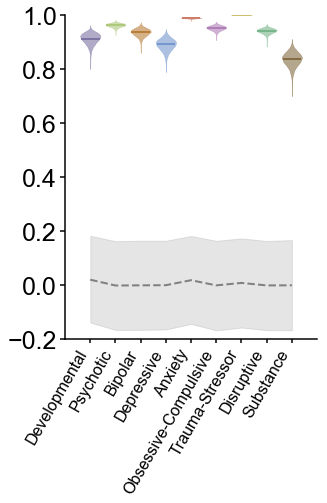

In [32]:
# Set up figure
fig = plt.figure(figsize=(3.5, 4.5))
ax = fig.add_axes([0,0,1,1])

# Null distributions as line plot
plt.plot(range(len(doms)), sim_null.mean(axis=1),
         "gray", linestyle="dashed", linewidth=2)
plt.fill_between(range(len(doms)), lower, y2=upper, 
                 color="gray", alpha=0.2)

# Bootstrap distributions as violin plots
for i, dom in enumerate(doms):
    for data, obs in [(sim_boot, sim_obs)]:
        data = sorted(data[i])
        v = ax.violinplot(data, positions=[i], 
                          showmeans=False, showmedians=False, widths=0.8)
        for pc in v["bodies"]:
            pc.set_facecolor(palette[i])
            pc.set_edgecolor(palette[i])
            pc.set_linewidth(0.5)
            pc.set_alpha(0.6)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")
        plt.plot([i-0.33, i+0.33], [np.mean(obs[i]), np.mean(obs[i])], 
                 c=palette[i], alpha=1, lw=2)

# Set plot parameters
ax.set_xticks(range(len(doms)))
ax.set_xticklabels(dom_names, rotation=60, 
                   ha="right", fontproperties=prop_md)
plt.xticks(fontproperties=prop_md)
plt.yticks(fontproperties=prop_xlg)
ax.yaxis.set_label_coords(-0.35, 0.5)
plt.xlim([-1, len(doms)])
plt.ylim([-0.2, 1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5, length=5)

# Export figure
plt.savefig("figures/dsm_seed_sim.png", dpi=250, bbox_inches="tight")
plt.show()

# Visualize the term lists

In [33]:
dtm_bin = load_doc_term_matrix(version=dtm_version, binarize=True)

DEVELOPMENTAL


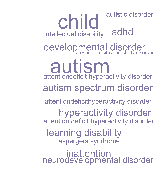

PSYCHOTIC


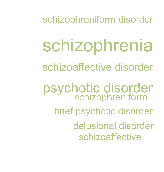

BIPOLAR


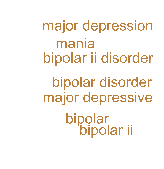

DEPRESSIVE


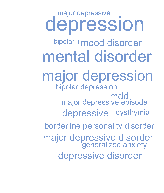

ANXIETY


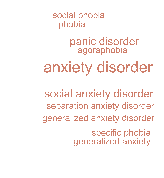

OBSESSIVE_COMPULSIVE


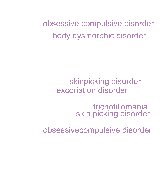

TRAUMA_STRESSOR


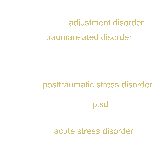

DISRUPTIVE


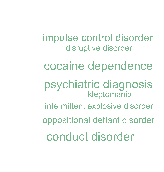

SUBSTANCE


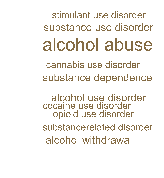

In [34]:
plot_wordclouds("dsm", doms, new, dtm_bin)

# Visualize the circuits

## Compute PPMI-weighted links

In [35]:
act_bin = load_coordinates()
print("Document N={}, Structure N={}".format(act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


In [36]:
scores = score_lists(new, dtm_bin, label_var="DOMAIN")
print("Document N={}, Structure N={}".format(scores.shape[0], scores.shape[1]))

Document N=18155, Structure N=9


In [37]:
pmids = act_bin.index.intersection(scores.index)
len(pmids)

18155

In [38]:
act_bin = act_bin.loc[pmids]
scores = scores.loc[pmids]

In [39]:
dom_links = compute_cooccurrences(act_bin, scores)

In [40]:
n_iter = 10000
dom_links_null = compute_cooccurrences_null(act_bin, scores, 
                                            n_iter=n_iter, verbose=True)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [41]:
p = pd.DataFrame(index=act_bin.columns, columns=scores.columns)
for i, struct in enumerate(act_bin.columns):
    for j, dom in enumerate(scores.columns):
        obs = dom_links.values[i,j]
        null = dom_links_null[i,j,:]
        p.loc[struct, dom] = np.sum(null > obs) / float(n_iter)

In [42]:
fdr = multipletests(p.values.ravel(), method="fdr_bh")[1]
fdr = pd.DataFrame(fdr.reshape(p.shape), 
                   index=act_bin.columns, columns=scores.columns)

In [43]:
dom_links_thres = dom_links[fdr < 0.01]
dom_links_thres = dom_links_thres.fillna(0.0)

In [44]:
dom_links_thres.to_csv("circuits/circuits_dsm.csv")

## Map PPMI-weighted links

In [45]:
atlas = load_atlas()

In [46]:
purples = make_cmap([(1,1,1), (0.365,0,0.878)])
chartreuses = make_cmap([(1,1,1), (0.345,0.769,0)])
magentas = make_cmap([(1,1,1), (0.620,0,0.686)])
yellows = make_cmap([(1,1,1), (0.937,0.749,0)])
browns = make_cmap([(1,1,1), (0.82,0.502,0)])
cmaps = [purples, chartreuses, "Oranges", "Blues", 
         "Reds", magentas, yellows, "Greens", browns]

DEVELOPMENTAL        Min: 0.0000  Mean: 0.0270  Max: 0.1766


/Users/ehbeam/.local/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:285: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


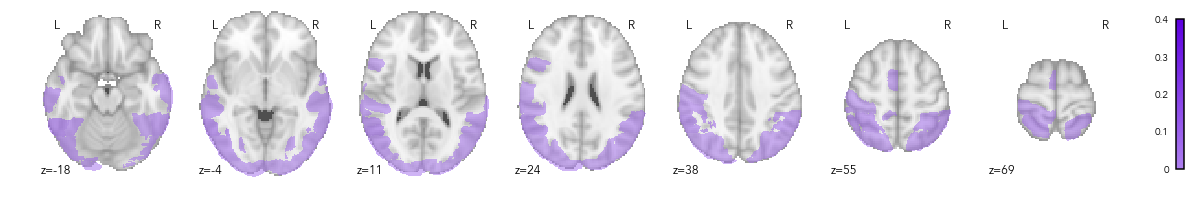

PSYCHOTIC            Min: 0.0000  Mean: 0.0075  Max: 0.0913


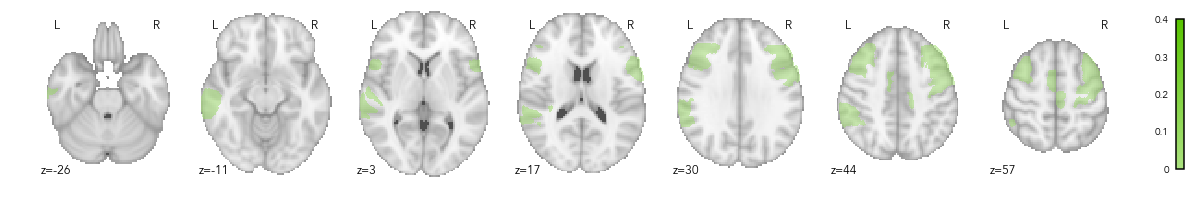

BIPOLAR              Min: 0.0000  Mean: 0.0037  Max: 0.0992


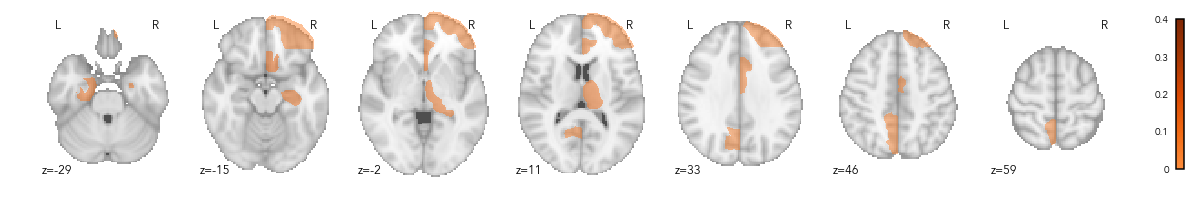

DEPRESSIVE           Min: 0.0000  Mean: 0.0021  Max: 0.0665


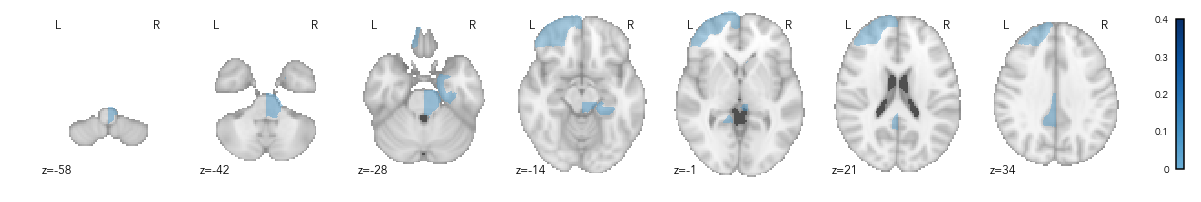

ANXIETY              Min: 0.0000  Mean: 0.0151  Max: 0.3212


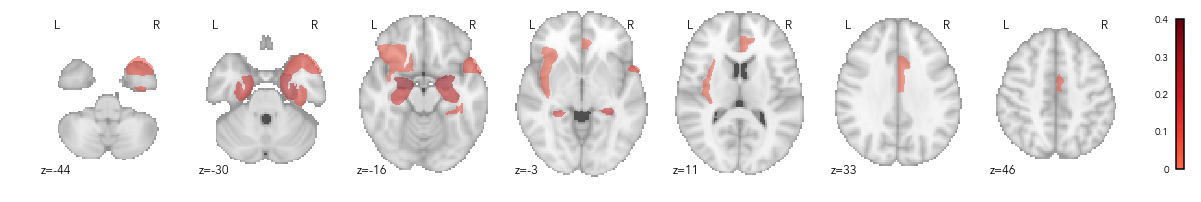

OBSESSIVE_COMPULSIVE Min: 0.0000  Mean: 0.0075  Max: 0.2010


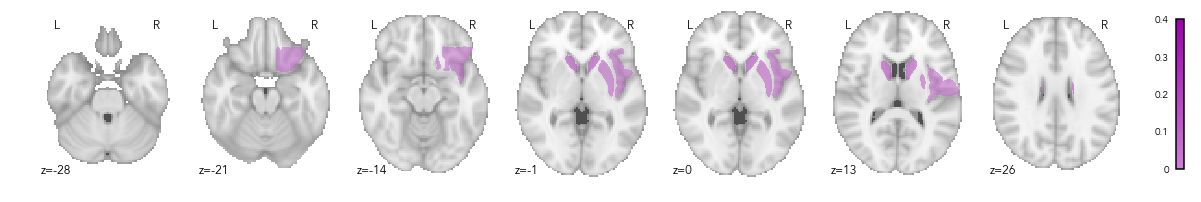

TRAUMA_STRESSOR      Min: 0.0000  Mean: 0.0205  Max: 0.3902


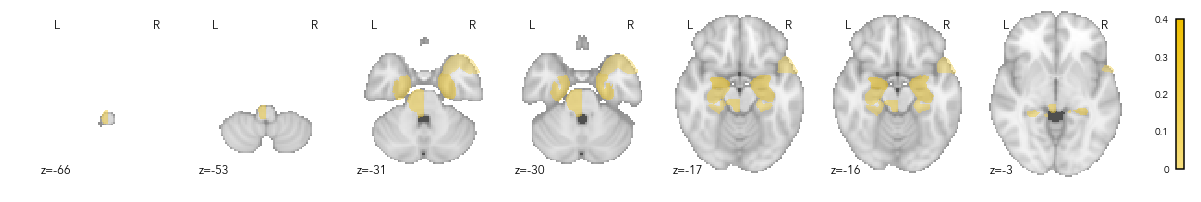

DISRUPTIVE           Min: 0.0000  Mean: 0.0150  Max: 0.3479


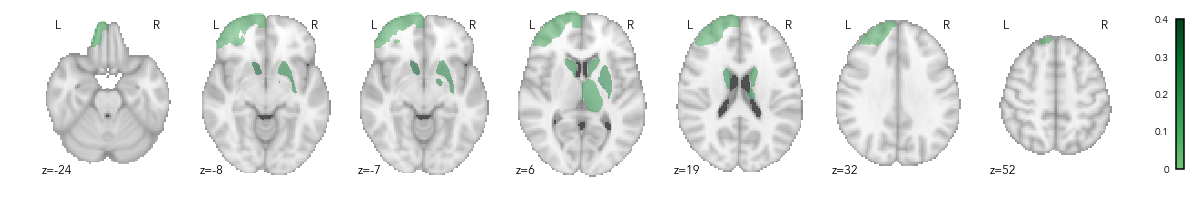

SUBSTANCE            Min: 0.0000  Mean: 0.0080  Max: 0.2965


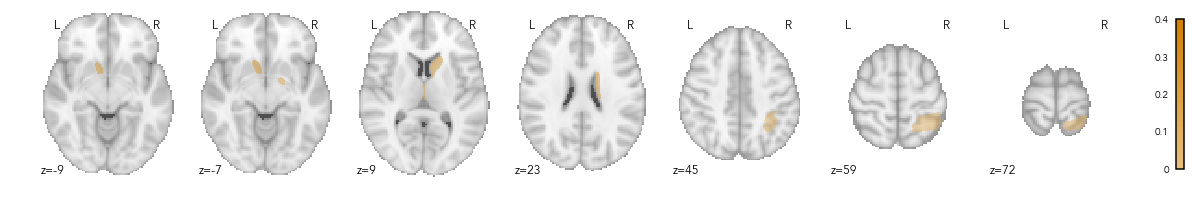

In [47]:
map_plane(dom_links_thres, atlas, "figures/circuits/dsm", suffix="_z", 
          cmaps=cmaps, plane="z", cbar=True, vmin=0.0, vmax=0.4,
          verbose=True, print_fig=True, annotate=True)

In [48]:
for plane in ["x", "y"]:
    map_plane(dom_links_thres, atlas, "figures/circuits/dsm", suffix="_"+plane, 
              cmaps=cmaps, plane=plane, cbar=True, vmin=0.0, vmax=0.4,
              verbose=False, print_fig=False, annotate=True)